In [9]:
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix, train as train_xgb, cv
import pickle

import numpy as np
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

In [10]:
import onnxruntime as rt
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes
)
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [12]:
import warnings

warnings.filterwarnings('ignore')

__XGBoost stands for Extreme Gradient Boosting. It is an implementation of gradient boosted trees designed for speed and accuracy.__

In [13]:
capture_34_dataset = "D:/Course_Content/2ES/IOT_IDS/Model/CTU-IoT-Malware-Capture-34-1/conn.log.labeled"
df_c = pd.read_table(filepath_or_buffer=capture_34_dataset, skiprows=10, nrows=100000)
df_c.columns=  ['ts',
              'uid',
              'id.orig_h', 
              'id.orig_p',
              'id.resp_h',
              'id.resp_p',
              'proto',
              'service',
              'duration',
              'orig_bytes',
              'resp_bytes',
              'conn_state',
              'local_orig',
              'local_resp',
              'missed_bytes',
              'history',
              'orig_pkts',
              'orig_ip_bytes',
              'resp_pkts',
              'resp_ip_bytes',
              'label']

In [14]:
df_c['label'].value_counts()

-   Malicious   DDoS                         14394
-   Malicious   C&C                           6706
-   Benign   -                                1920
-   Malicious   PartOfAHorizontalPortScan      122
Name: label, dtype: int64

In [15]:
df_c.loc[(df_c.label == '-   Malicious   PartOfAHorizontalPortScan'), 'label'] = 'PartOfAHorizontalPortScan'
df_c.loc[(df_c.label == '(empty)   Malicious   PartOfAHorizontalPortScan'), 'label'] = 'PartOfAHorizontalPortScan'
df_c.loc[(df_c.label == '-   Benign   -'), 'label'] = 'Benign'
df_c.loc[(df_c.label == '(empty)   Benign   -'), 'label'] = 'Benign'
df_c.loc[(df_c.label == '-   Malicious   DDoS'), 'label'] = 'DDoS'
df_c.loc[(df_c.label == '-   Malicious   C&C'), 'label'] = 'C&C'
df_c.loc[(df_c.label == '(empty)   Malicious   C&C'), 'label'] = 'C&C'

In [16]:
df_c['label'].value_counts()

DDoS                         14394
C&C                           6706
Benign                        1920
PartOfAHorizontalPortScan      122
Name: label, dtype: int64

In [17]:
df_c = df_c.drop(columns=['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p', 'service','local_orig','local_resp','history'])

In [18]:
df_c = pd.get_dummies(df_c, columns=['proto'])
df_c = pd.get_dummies(df_c, columns=['conn_state'])

In [19]:
df_c['duration'] = df_c['duration'].str.replace('-','0')
df_c['orig_bytes'] = df_c['orig_bytes'].str.replace('-','0')
df_c['resp_bytes'] = df_c['resp_bytes'].str.replace('-','0')
df_c

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
0,1.477656,149,128252,2896.0,94.0,5525.0,96.0,139044.0,Benign,1,0,0,0,0,0,0,1
1,3.147116,0,0,0.0,3.0,180.0,0.0,0.0,Benign,1,0,0,0,1,0,0,0
2,1.305004,151,128348,5792.0,96.0,5699.0,92.0,133140.0,Benign,1,0,0,0,0,0,0,1
3,1.004605,148,91961,2896.0,67.0,4148.0,65.0,92453.0,Benign,1,0,0,0,0,0,0,1
4,4.129647,148,99303,5792.0,75.0,4412.0,69.0,97107.0,Benign,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23138,36.290833,62,260,0.0,10.0,606.0,7.0,632.0,C&C,1,0,0,0,0,0,1,0
23139,0,0,0,0.0,1.0,76.0,0.0,0.0,Benign,0,1,0,0,1,0,0,0
23140,0,0,0,0.0,1.0,76.0,0.0,0.0,Benign,0,1,0,0,1,0,0,0
23141,0,0,0,0.0,1.0,76.0,0.0,0.0,Benign,0,1,0,0,1,0,0,0


In [20]:
df_c.fillna(-1, inplace=True)
check=df_c.isna().sum()
check

duration           0
orig_bytes         0
resp_bytes         0
missed_bytes       0
orig_pkts          0
orig_ip_bytes      0
resp_pkts          0
resp_ip_bytes      0
label              0
proto_tcp          0
proto_udp          0
conn_state_OTH     0
conn_state_RSTR    0
conn_state_S0      0
conn_state_S1      0
conn_state_S3      0
conn_state_SF      0
dtype: int64

In [21]:
df_c

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
0,1.477656,149,128252,2896.0,94.0,5525.0,96.0,139044.0,Benign,1,0,0,0,0,0,0,1
1,3.147116,0,0,0.0,3.0,180.0,0.0,0.0,Benign,1,0,0,0,1,0,0,0
2,1.305004,151,128348,5792.0,96.0,5699.0,92.0,133140.0,Benign,1,0,0,0,0,0,0,1
3,1.004605,148,91961,2896.0,67.0,4148.0,65.0,92453.0,Benign,1,0,0,0,0,0,0,1
4,4.129647,148,99303,5792.0,75.0,4412.0,69.0,97107.0,Benign,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23138,36.290833,62,260,0.0,10.0,606.0,7.0,632.0,C&C,1,0,0,0,0,0,1,0
23139,0,0,0,0.0,1.0,76.0,0.0,0.0,Benign,0,1,0,0,1,0,0,0
23140,0,0,0,0.0,1.0,76.0,0.0,0.0,Benign,0,1,0,0,1,0,0,0
23141,0,0,0,0.0,1.0,76.0,0.0,0.0,Benign,0,1,0,0,1,0,0,0


In [22]:
df_c = df_c[df_c['label'] != -1]
label_counts=df_c['label'].value_counts()

In [23]:
df_c.describe()

,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_tcp,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
count,23142.000000,23142.000000,2.314200e+04,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000
mean,2.127387,6.375767,3.664774e+03,0.611097,111.233385,0.921614,0.078386,0.616196,0.002290,0.276208,0.000173,0.068447,0.036687
std,102.497428,178.560290,5.004086e+05,8.306434,2713.258383,0.268783,0.268783,0.486322,0.047802,0.447130,0.013146,0.252517,0.187995
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,7.600000e+01,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df_c.isnull().sum()


duration           0
orig_bytes         0
resp_bytes         0
missed_bytes       0
orig_pkts          0
orig_ip_bytes      0
resp_pkts          0
resp_ip_bytes      0
label              0
proto_tcp          0
proto_udp          0
conn_state_OTH     0
conn_state_RSTR    0
conn_state_S0      0
conn_state_S1      0
conn_state_S3      0
conn_state_SF      0
dtype: int64

There are no missing values in the dataset.

In [25]:
table_format = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
display(table_format)

,Label,Count
0,DDoS,14394
1,C&C,6706
2,Benign,1920
3,PartOfAHorizontalPortScan,122


In [26]:
IP = df_c.drop('label', axis=1)

OP = df_c['label']

In [27]:
IP

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_tcp,proto_udp,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF
0,1.477656,149,128252,2896.0,94.0,5525.0,96.0,139044.0,1,0,0,0,0,0,0,1
1,3.147116,0,0,0.0,3.0,180.0,0.0,0.0,1,0,0,0,1,0,0,0
2,1.305004,151,128348,5792.0,96.0,5699.0,92.0,133140.0,1,0,0,0,0,0,0,1
3,1.004605,148,91961,2896.0,67.0,4148.0,65.0,92453.0,1,0,0,0,0,0,0,1
4,4.129647,148,99303,5792.0,75.0,4412.0,69.0,97107.0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23137,32.840994,62,269,0.0,7.0,434.0,6.0,589.0,1,0,0,0,0,0,1,0
23138,36.290833,62,260,0.0,10.0,606.0,7.0,632.0,1,0,0,0,0,0,1,0
23139,0,0,0,0.0,1.0,76.0,0.0,0.0,0,1,0,0,1,0,0,0
23140,0,0,0,0.0,1.0,76.0,0.0,0.0,0,1,0,0,1,0,0,0


In [28]:
OP

0        Benign
1        Benign
2        Benign
3        Benign
4        Benign
          ...  
23137       C&C
23138       C&C
23139    Benign
23140    Benign
23141    Benign
Name: label, Length: 23142, dtype: object

In [29]:
OP[OP == "DDoS"] = 0
OP[OP == "C&C"] = 1
OP[OP == "Benign"] = 2
OP[OP == "PartOfAHorizontalPortScan"] = 3

__conversion of the dataset to an optimized data structure called Dmatrix__

In [46]:
for column in IP.columns:
    if IP[column].dtype == 'object':
        IP[column] = IP[column].astype('category')
    else:
        IP[column] = pd.to_numeric(IP[column])

OP = OP.astype('int')

In [47]:
OP.unique()

array([2, 1, 3, 0])

In [49]:
import xgboost as xgb

In [50]:
try:
    data_dmatrix = xgb.DMatrix(data=IP, label=OP, enable_categorical=True)
    print("DMatrix created successfully")
except ValueError as e:
    print(f"Error creating DMatrix: {e}")

DMatrix created successfully


In [52]:
X_train, X_test, y_train, y_test = train_test_split(IP, OP, test_size = 0.3, random_state = 0)


In [53]:
X_train.shape[0], X_train.shape[1]


(16199, 16)

## Training a Model with XGBClassifier

__This also includes model optimization by Hyperparameter tuning using GridSearchCV__

In [54]:
from xgboost import XGBClassifier

In [55]:
params = {
    'objective': ['multi:softmax'], 
    'max_depth': [3, 5, 7],
    'alpha': [10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'num_class': [4],
    'colsample_bytree': [0.3, 0.7]
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'num_class': 4, 'objective': 'multi:softmax'}


In [56]:
xgb_model = xgb.XGBClassifier(early_stopping_rounds=10, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:0.86383
[1]	validation_0-mlogloss:0.59593
[2]	validation_0-mlogloss:0.42729
[3]	validation_0-mlogloss:0.31375
[4]	validation_0-mlogloss:0.23475
[5]	validation_0-mlogloss:0.17874
[6]	validation_0-mlogloss:0.13859
[7]	validation_0-mlogloss:0.10957
[8]	validation_0-mlogloss:0.08847
[9]	validation_0-mlogloss:0.07314
[10]	validation_0-mlogloss:0.06195
[11]	validation_0-mlogloss:0.05378
[12]	validation_0-mlogloss:0.04783
[13]	validation_0-mlogloss:0.04348
[14]	validation_0-mlogloss:0.04038
[15]	validation_0-mlogloss:0.03801
[16]	validation_0-mlogloss:0.03637
[17]	validation_0-mlogloss:0.03511
[18]	validation_0-mlogloss:0.03411
[19]	validation_0-mlogloss:0.03333
[20]	validation_0-mlogloss:0.03274
[21]	validation_0-mlogloss:0.03228
[22]	validation_0-mlogloss:0.03203
[23]	validation_0-mlogloss:0.03182
[24]	validation_0-mlogloss:0.03167
[25]	validation_0-mlogloss:0.03153
[26]	validation_0-mlogloss:0.03150
[27]	validation_0-mlogloss:0.03142
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [57]:
y_pred = xgb_model.predict(X_test)

In [58]:
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.9891


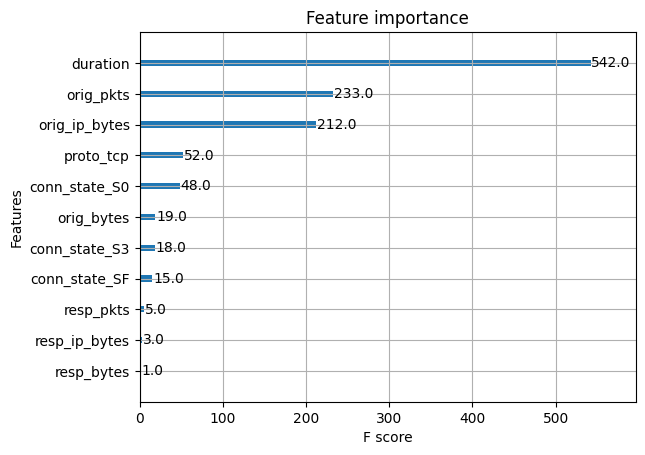

In [59]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'num_class': 4, 'objective': 'multi:softmax'}

### __Convert to ONNX {Open Neural Network Exchange} model format__

In [60]:
pipe = Pipeline([("scaler", StandardScaler()), ("xgb", XGBClassifier(n_estimators=100, 
                                                                      max_depth=5, 
                                                                      learning_rate=0.3, 
                                                                      colsample_bytree=0.7, 
                                                                      alpha=10, 
                                                                      objective='multi:softmax', 
                                                                      num_class=4))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree',
                               callbacks=None, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=0.7,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.3, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_class=4,
                               num_parallel_tree=1, objective='multi:

In [61]:
update_registered_converter(
    XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
#     options=None,
#     options={'zipmap': False},
)

In [62]:
try:
    model_onnx = convert_sklearn(
        pipe,
        "pipeline_xgboost",
        [("input", FloatTensorType([None, X_train.shape[1]]))],
        target_opset={"": 14, "ai.onnx.ml": 2},
        options={'zipmap': False}
    )

    with open("xgboost_model.onnx", "wb") as f:
        f.write(model_onnx.SerializeToString())

    print("Model converted and saved successfully.")

except Exception as e:
    print(f"An error occurred during the conversion: {e}")

Model converted and saved successfully.


### Quantize the obtained ONNX model

In [63]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType, quantize_static

In [64]:
onnx_model_path = "D:\\Course_Content\\2ES\\IOT_IDS\\Model\\XGBoost\\xgboost_model.onnx"

In [65]:
quantized_model_path = "D:\\Course_Content\\2ES\\IOT_IDS\\Model\\XGBoost\\xgboost_model_quantized.onnx"

In [66]:
quantized_model = quantize_dynamic(
    onnx_model_path,
    quantized_model_path,
    weight_type=QuantType.QInt8
)

In [67]:
# import tensorflow as tf

# # Load the ONNX model
# interpreter = tf.lite.Interpreter(onnx_model_path)
# interpreter.allocate_tensors()

# # Convert to TFLite (adjust options as needed)
# converter = tf.lite.TFLiteConverter.from_interpreter(interpreter)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()

# # Save the quantized TFLite model
# with open("pipeline_xgboost_quantized_tflite", "wb") as f:
#     f.write(tflite_model)

In [188]:
session = rt.InferenceSession(quantized_model_path)

sampled_data = IP.sample(n=1)

input_data = np.array(sampled_data, dtype=np.float32)
input_data = input_data.reshape(1, -1)
input_name = session.get_inputs()[0].name

outputs = session.run(None, {input_name: input_data})
output_data = outputs[0]

print("Model Output:", output_data)


Model Output: [2]
Predicted Label: 0
